# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import np_utils
from sklearn import metrics as me

%matplotlib inline

Using TensorFlow backend.


Load the `mnist` dataset and normalize in the range [0, 1]

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [4]:
n_orientations = 8
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [5]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualise=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

/usr/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/usr/lib/python3.6/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Show the image and the corresponding gradients

/usr/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


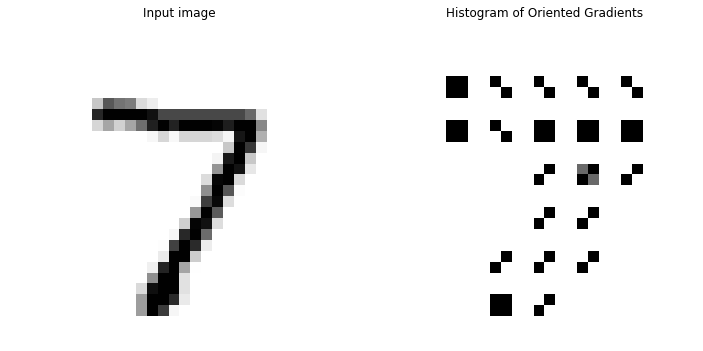

In [6]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')

Compute the HOGs for the train and test datasets

In [7]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualise=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualise=False)
print('X_test done')
print(X_train_hog.shape)

X_train done
X_test done
(60000, 392)


Create the MLP

In [8]:
neurons = [i for i in range(50,350,50)]
score_n = []
accuracy_n = []
for n in neurons:
    model = Sequential()
    model.add(Dense(n, input_shape=(hog_size,), activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()
    batch_size = 128
    n_epoch = 10

    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    history = model.fit(X_train_hog, Y_train,
                        batch_size=batch_size, epochs=n_epoch,
                        verbose=1, validation_data=(X_test_hog, Y_test))
    score = model.evaluate(X_test_hog, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    score_n.append(score[0])
    accuracy_n.append(score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                19650     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 20,160
Trainable params: 20,160
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.4106 - acc: 0.9194 - val_loss: 0.1189 - val_acc: 0.9666
Epoch 2/10
60000/60000 [==============================] - 1s 12us/step - loss: 0.1116 - acc: 0.9664 - val_loss: 0.0927 - val_acc: 0.9713
Epoch 3/10
60000/60000 [==============================] - 1s 12us/step - loss: 0.0916 - acc: 0.9720 - val_loss: 0.0839 - val_acc: 0.9741
Epoch 4/10
60000/60000 [==============================] - 1s 12us/step - 

Test score: 0.06316232326992322
Test accuracy: 0.9797
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 250)               98250     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                2510      
Total params: 100,760
Trainable params: 100,760
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 15us/step - loss: 0.2425 - acc: 0.9429 - val_loss: 0.0937 - val_acc: 0.9696
Epoch 2/10
60000/60000 [==============================] - 1s 13us/step - loss: 0.0888 - acc: 0.9716 - val_loss: 0.0813 - val_acc: 0.9730
Epoch 3/10
60000/60000 [==============================] - 1s 13us/step - loss: 0.0739 - acc: 0.9763 - val_loss: 0.0745 - val_acc: 0.9757
Epoch 4/10
60000/

Define some constants and train the MLP

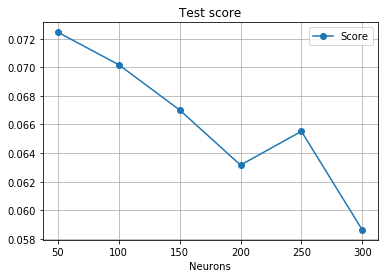

In [9]:
df = pd.DataFrame({
    'Neurons':neurons,
    'Score':score_n,
    'Accuracy':accuracy_n,
})

#ax = pl.gca()

df.plot(kind='line',x='Neurons',y='Score',style='-o')
pl.title('Test score')
#df.plot(kind='line',x='Neurons',y='Accuracy', color='red', ax=ax)
pl.grid()
pl.show()

Show the performance of the model

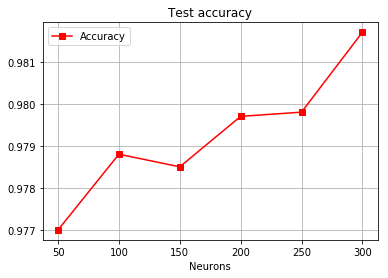

In [10]:
df.plot(kind='line',x='Neurons',y='Accuracy', color='red',style='-s')
pl.title('Test accuracy')
pl.grid()
pl.show()

Confusion matrix

In [11]:
pred = model.predict_classes(X_test_hog)
me.confusion_matrix(y_test, pred)

array([[ 964,    0,    2,    1,    0,    2,    7,    0,    3,    1],
       [   0, 1124,    1,    1,    0,    1,    2,    2,    4,    0],
       [   1,    1, 1013,    2,    1,    0,    2,    7,    5,    0],
       [   0,    0,    1,  997,    0,    5,    0,    3,    4,    0],
       [   1,    2,    1,    0,  957,    0,    1,    3,    3,   14],
       [   2,    1,    0,   10,    0,  869,    3,    1,    5,    1],
       [   2,    3,    0,    1,    3,    4,  943,    0,    2,    0],
       [   0,    5,    2,    3,    2,    0,    0, 1008,    3,    5],
       [   2,    0,    2,   11,    0,    2,    0,    4,  948,    5],
       [   0,    5,    0,    5,    4,    4,    0,    8,    4,  979]])